In [2]:
import warnings



In [6]:
# Import libraries here


from glob import glob

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
# import wqet_grader
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted


In [22]:
# Build your `wrangle` function

def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset the data in the CSV file and return only apartments in Mexico City ("Distrito Federal") that cost less than $100,000.
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
   

    mask_price = df["price_aprox_usd"] < 100_000
    
    df = df[mask_ba & mask_apt &mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2" 删除低于10%分位和高于90%的异常值
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Mexico City is divided into 15 boroughs. Create a "borough" feature from the "place_with_parent_names" column.
    
    df["borough"]=df["place_with_parent_names"].str.split("|",expand = True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop columns that are more than 50% null values.

    df.drop(columns = ["surface_total_in_m2","price_usd_per_m2","floor","rooms","expenses"],inplace = True)
    
    # Drop columns containing low- or high-cardinality categorical values.
    
    df.drop(columns = ["operation","property_type","currency","properati_url"],inplace = True)
    
    # Drop any columns that would constitute leakage for the target "price_aprox_usd".
        # drop leaky varibles
    df.drop(columns = ['price','price_aprox_local_currency','price_per_m2',],inplace = True)
    df.drop(df.columns[0], axis=1, inplace=True)

    
    return df

In [23]:
df = wrangle("data/mexico-city-real-estate-1.csv")
df.info()
df.isnull().sum() / len(df) 

<class 'pandas.core.frame.DataFrame'>
Index: 1101 entries, 11 to 4605
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1101 non-null   float64
 1   surface_covered_in_m2  1101 non-null   float64
 2   lat                    1041 non-null   float64
 3   lon                    1041 non-null   float64
 4   borough                1101 non-null   object 
dtypes: float64(4), object(1)
memory usage: 51.6+ KB


price_aprox_usd          0.000000
surface_covered_in_m2    0.000000
lat                      0.054496
lon                      0.054496
borough                  0.000000
dtype: float64

In [24]:
df.select_dtypes("object").nunique()


borough    14
dtype: int64

<Axes: >

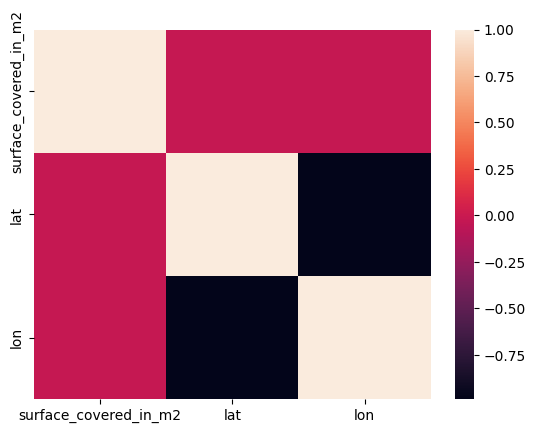

In [25]:
corr = df.select_dtypes("number").drop(columns = "price_aprox_usd").corr()
sns.heatmap(corr)

In [16]:
files = glob("data/mexico-city-real-estate-*.csv")
files

['data/mexico-city-real-estate-5.csv',
 'data/mexico-city-real-estate-4.csv',
 'data/mexico-city-real-estate-1.csv',
 'data/mexico-city-real-estate-3.csv',
 'data/mexico-city-real-estate-2.csv']

In [26]:
frames = [wrangle(file) for file in files]

# files 是一个文件路径的列表或迭代器，每个文件路径都可以作为参数传递给 wrangle 函数。


df = pd.concat(frames) 

# pd.concat() 是 Pandas 库中用于合并数据框的函数。
# frames 列表中的所有数据框会被沿着指定的轴（默认是行轴，即垂直方向）进行合并，生成一个新的大数据框 df。
# 如果数据框的列名和顺序相同，它们将被简单地垂直堆叠在一起。
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5473 entries, 1 to 4623
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
1,82737.39,75.0,19.362690,-99.150565,Benito Juárez
3,72197.60,62.0,19.291345,-99.124312,Tlalpan
4,44277.72,85.0,19.354987,-99.061709,Iztapalapa
13,60589.45,52.0,19.469681,-99.086136,Gustavo A. Madero
18,47429.08,53.0,19.443592,-99.121407,Venustiano Carranza


Text(0.5, 1.0, 'Distribution of Apartment Prices')

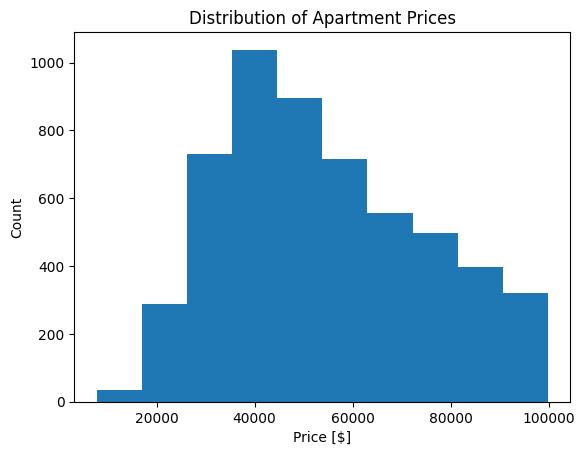

In [19]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes

plt.xlabel("Price [$]")
plt.ylabel("Count")



# Add title

plt.title("Distribution of Apartment Prices")

# Don't delete the code below 👇



Text(0.5, 1.0, 'Mexico City: Price vs. Area')

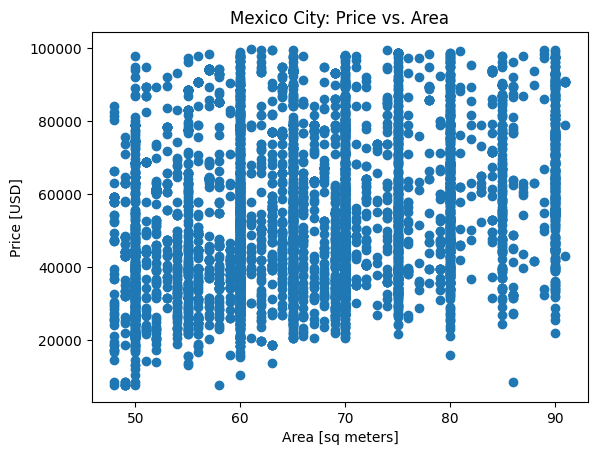

In [27]:
# Build scatter plot
plt.scatter(y=df["price_aprox_usd"],x=df["surface_covered_in_m2"])


# Label axes

plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")


# Add title

plt.title("Mexico City: Price vs. Area")





In [31]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,
    lat = "lat",
    lon = "lon",
    #center = {"lat": 19.6345, "lon": -99.5528},
    color = "price_aprox_usd", # 根据价格设置颜色
    width = 900,
    height = 600,
    hover_data = ["borough", "surface_covered_in_m2", "price_aprox_usd"] # Display price when hovering mouse over house
);

fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [32]:
# Split data into feature matrix `X_train` and target vector `y_train`.

target = "price_aprox_usd"
feature = []
for column in df.columns:
    if column != target:
        feature.append(column)
        
X_train = df[feature]
y_train = df[target]


In [33]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline) 
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


In [34]:
# Build Model
model = make_pipeline(
      OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    # Imputation（插补） 插补是指用某种方法来填补数据集中的缺失值。常见的方法包括：
    # LinearRegression()
    Ridge())

# make_pipeline：这是一个便利函数，用于创建一个包含多个步骤的管道。
# OneHotEncoder(use_cat_names=True)：这是独热编码器，将分类特征转换为独热编码格式。use_cat_names=True 表示编码后的列名将包含原始特征的名称和类别。
# LinearRegression()：这是一个线性回归模型，用于预测目标变量
# 数据预处理：

# OneHotEncoder 将 X_train 中的分类特征转换为独热编码格式。这一步确保分类数据被正确转换为数值数据，以便线性回归模型可以处理。
# 模型训练：

# 使用转换后的数据，LinearRegression 模型进行训练。它会找到最适合的线性关系，以便能够预测新的输入数据。


# 自动命名：在使用 make_pipeline 时，Pipeline 会根据步骤的类名自动生成名称，这些名称是类名的小写形式。

# OneHotEncoder 的自动生成名称是 onehotencoder。
# Ridge 的自动生成名称是 ridge。
    
# Fit model
model.fit(X_train, y_train)

# fit 方法执行完毕后，模型就被训练好了，可以用于对新的未见过的数据进行预测。

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [38]:


X_test = pd.read_csv("data/mexico-city-test-features.csv")
X_test.drop(X_test.columns[0], axis=1, inplace=True)
# print(X_test.info())
X_test.head()

,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


In [39]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

In [42]:

# named_steps 属性允许你在 Pipeline 中方便地访问和操作各个步骤的对象
coefficients = model.named_steps["ridge"].coef_

# coef_：获取 Ridge 回归模型的系数（或权重），这些系数表示模型学习到的各个特征对目标变量的影响程度。
features = model.named_steps["onehotencoder"].get_feature_names_out()

# model.named_steps["onehotencoder"]：假设 onehotencoder 是在管道中用于对分类特征进行独热编码的步骤。
# get_feature_names()：获取经过独热编码后的特征名列表。独热编码将原始的分类特征转换为多个二元（0/1）特征，每个特征代表一个可能的类别或取值。

feat_imp = pd.Series(coefficients, index = features)
feat_imp

# coefficients 记录了模型学习到的每个特征的权重大小。
# features 是独热编码后的特征名列表，将每个分类变量的各个类别转换为二进制特征。
# feat_imp 将每个独热编码后的特征名与其对应的系数结合起来，帮助理解模型如何利用这些特征进行预测。


surface_covered_in_m2               291.654156
lat                                 478.901375
lon                               -2492.221814
borough_Benito Juárez             13778.188880
borough_Tlalpan                   10319.429804
borough_Iztapalapa               -13349.017448
borough_Gustavo A. Madero         -6637.429757
borough_Venustiano Carranza       -5609.918629
borough_Iztacalco                   405.403127
borough_Coyoacán                   3737.561001
borough_Cuauhtémoc                 -350.531990
borough_Miguel Hidalgo             1977.314718
borough_Azcapotzalco               2459.288646
borough_Tláhuac                  -14166.869486
borough_Álvaro Obregón             3275.121061
borough_La Magdalena Contreras    -5925.666450
borough_Xochimilco                  929.857400
borough_Cuajimalpa de Morelos      9157.269123
dtype: float64

Text(0.5, 1.0, 'Feature Importance for Apartment Price')

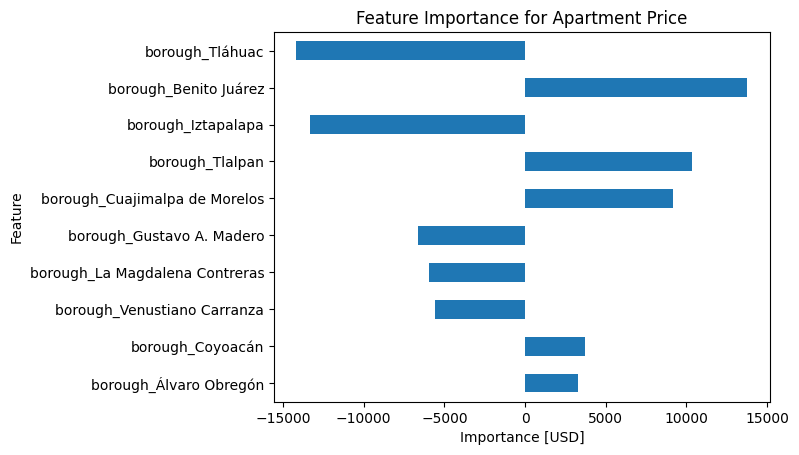

In [43]:
feat_imp.sort_values(key = abs).tail(10).plot(kind = "barh")
# feat_imp = pd.Series(coefficients, index = feature_names)
# feat_imp:

# 这是一个 pandas Series 对象，包含模型中特征的重要性。Series 的索引是特征名称，值是它们的重要性。
# sort_values(key=abs):

# 这个方法对 feat_imp 进行排序，key=abs 指定了排序的关键是特征重要性的绝对值。这样可以按照特征影响力的大小进行排序，而不考虑它们的正负方向。
# tail(15):

# 这个方法返回排序后的最后 15 个特征。因为我们已经按绝对值进行了排序，tail(15) 将返回影响力最大的 15 个特征。
# plot(kind="barh"):

# 这个方法生成一个水平条形图（horizontal bar plot），用于可视化特征的重要性。
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price")

# sort_values
# sort_values 是 pandas Series 的一个方法，用于对数据进行排序。

# key=abs
# key=abs 是 sort_values 方法的一个参数，它指定排序时使用的键函数。在这个例子中，abs 是 Python 内置的绝对值函数。

# feat_imp.sort_values(key=abs).tail(15).plot(kind="barh") 这段代码通过按绝对值排序特征重要性，并提取影响力最大的 15 个特征，然后生成一个水平条形图，直观地展示了这些特征的重要性。这个过程有助于理解和解释模型，尤其是确定哪些特征对模型预测有最大贡献。
# Don't delete the code below 👇

